Я на кэгл:
https://www.kaggle.com/pusinka
Лаура Гондарева

In [1]:
import numpy as np
import pandas as pd
import pickle as pic
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor, plot_tree

import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
mat.rcParams.update({'font.size': 14})

In [4]:
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'
PREPARED_DATASET_PATH_TRAIN = './data/train.csv'
PREPARED_DATASET_PATH_TEST = './data/test.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [7]:
#### Уменьшение объема памяти, который занимает датасет

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [11]:
#### функция для обработки выбросов, значения которых больше 97,5% квантиля и которые меньше 2,5% квантиля будем 
#### считать выбросами и заменять на медиану.
def Quan_median(df, column):
    c_max = np.quantile(df[column], q=0.975)
    c_min = np.quantile(df[column], q=0.025)
    cons = (df[column] > c_max) | (df[column] < c_min)
    df.loc[cons, column] = df[column].median()
    
# для Floor и HouseFloor
def Fl_HF(df):
    Floor_mode = df['Floor'].mode()[0]
    HouseFloor_mode = df['HouseFloor'].mode()[0]
    df.loc[(df['HouseFloor']==0) & (HouseFloor_mode >= df['Floor']),'HouseFloor'] = HouseFloor_mode 
    df.loc[(df['HouseFloor']==0) & (HouseFloor_mode < df['Floor']),'HouseFloor'] = df['Floor']
    df.loc[(df['HouseFloor'] < df['Floor'])&(HouseFloor_mode >= df['Floor']), 'HouseFloor'] = HouseFloor_mode
    df.loc[(df['HouseFloor'] < df['Floor'])&(HouseFloor_mode < df['Floor']), 'HouseFloor'] = df['Floor']

In [12]:
#### функция для подсчёта метрик
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Визуализация и анализ признаков

##### Целевая перменная

In [13]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

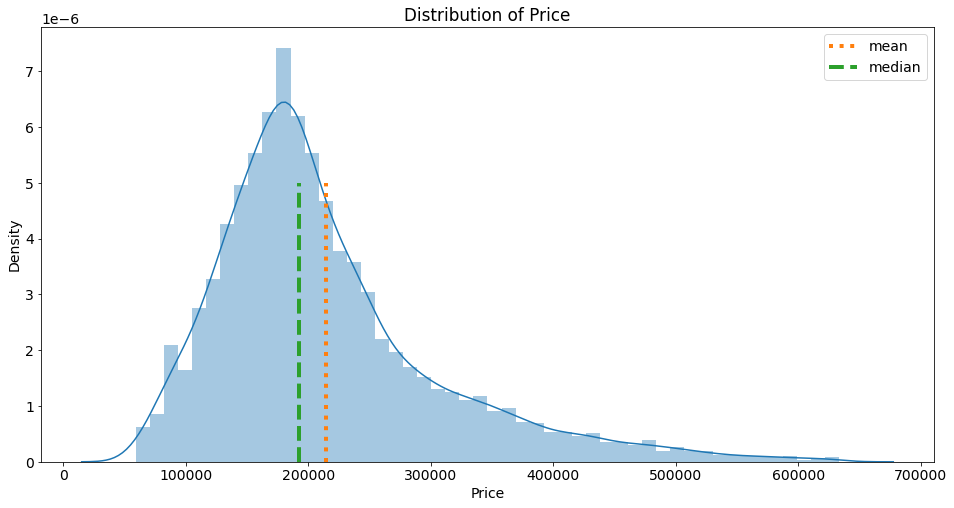

In [14]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50) 

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

#### Количественные переменные

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [16]:
df_num_features = train_df.select_dtypes(include=['float32', 'int8', 'int16', 'int32'])
df_num_features.drop('Price', axis=1, inplace=True)

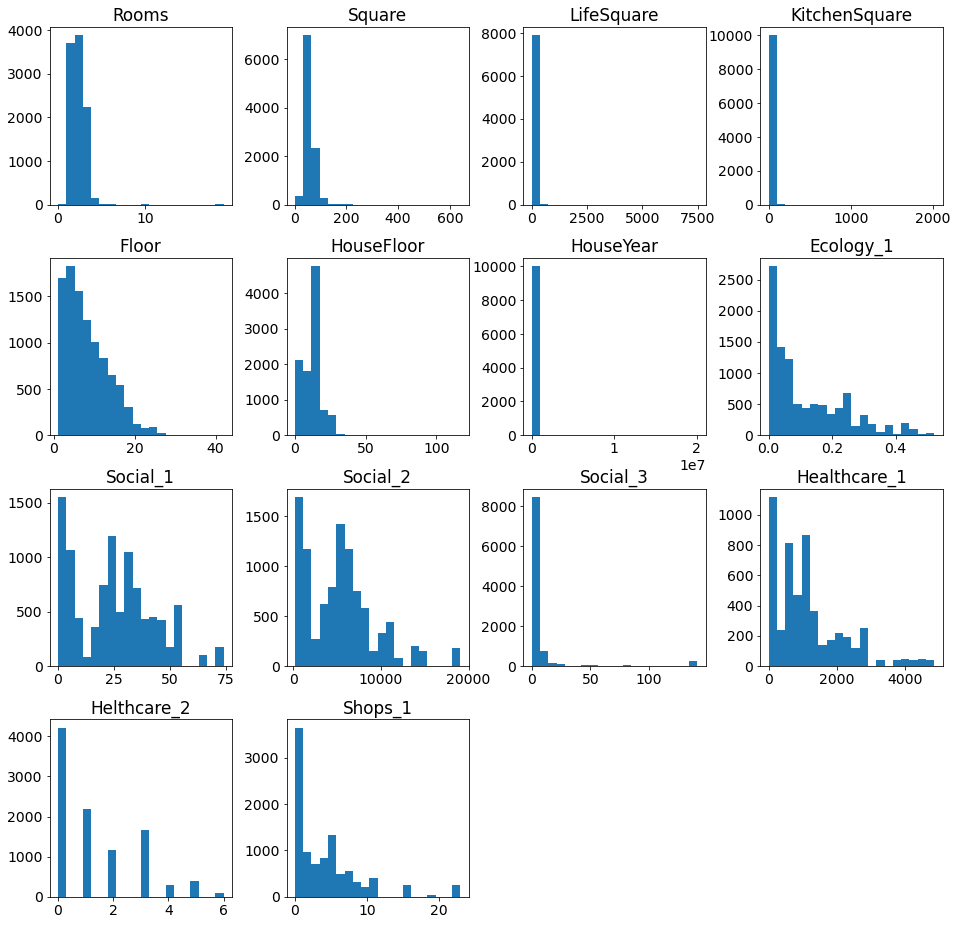

In [17]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

#### Качественные переменные

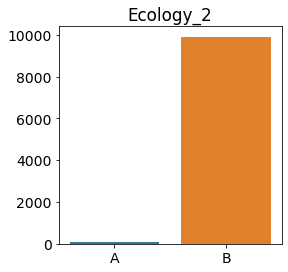

In [18]:
counts = train_df['Ecology_2'].value_counts()
    
plt.figure(figsize=(4, 4))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

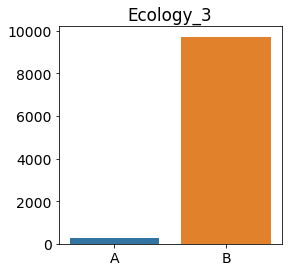

In [19]:
counts = train_df['Ecology_3'].value_counts()
    
plt.figure(figsize=(4, 4))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
    
plt.show()

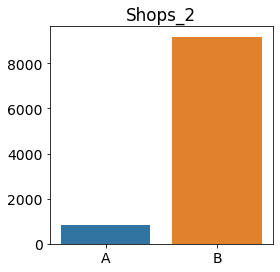

In [20]:
counts = train_df['Shops_2'].value_counts()
    
plt.figure(figsize=(4, 4))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

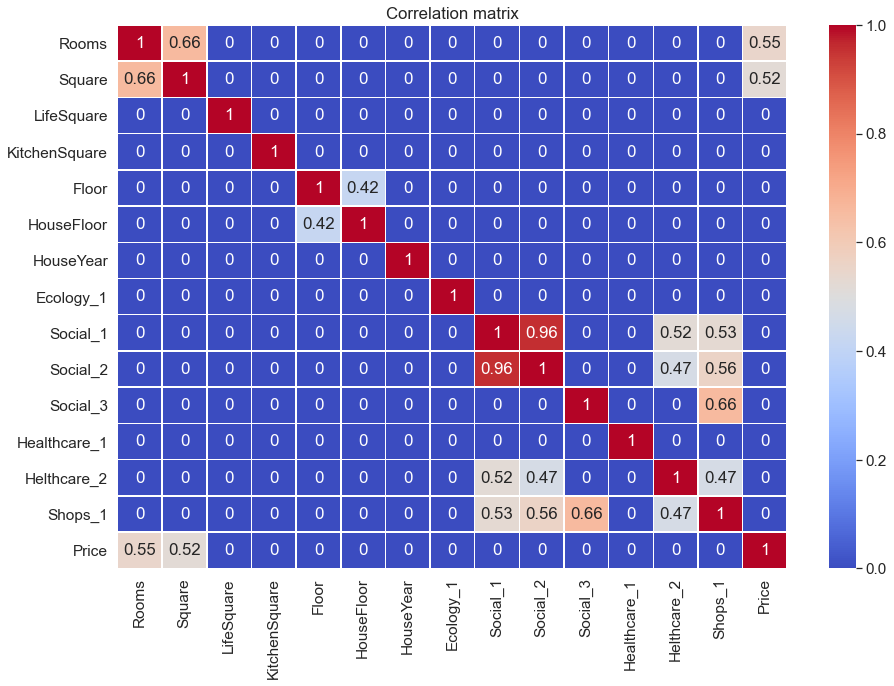

In [21]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Очевидно, что нужно поработать над выбросами во многих категориях

#### Посмотрим на зависимость целевой пемереммой от категориальных признаков

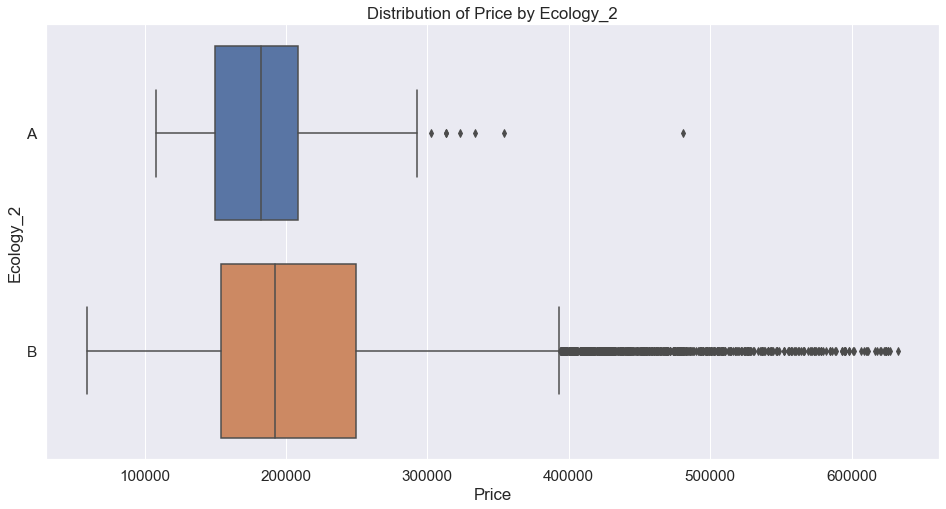

In [22]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['Price'], train_df['Ecology_2'], whis=1.5)

plt.xlabel('Price')
plt.ylabel('Ecology_2')
plt.title('Distribution of Price by Ecology_2')
plt.show()

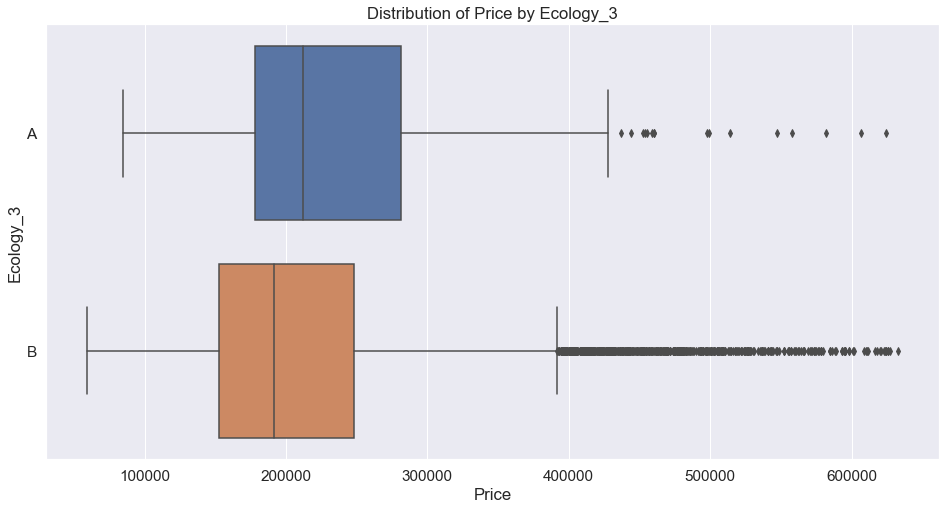

In [23]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['Price'], train_df['Ecology_3'], whis=1.5)

plt.xlabel('Price')
plt.ylabel('Ecology_3')
plt.title('Distribution of Price by Ecology_3')
plt.show()

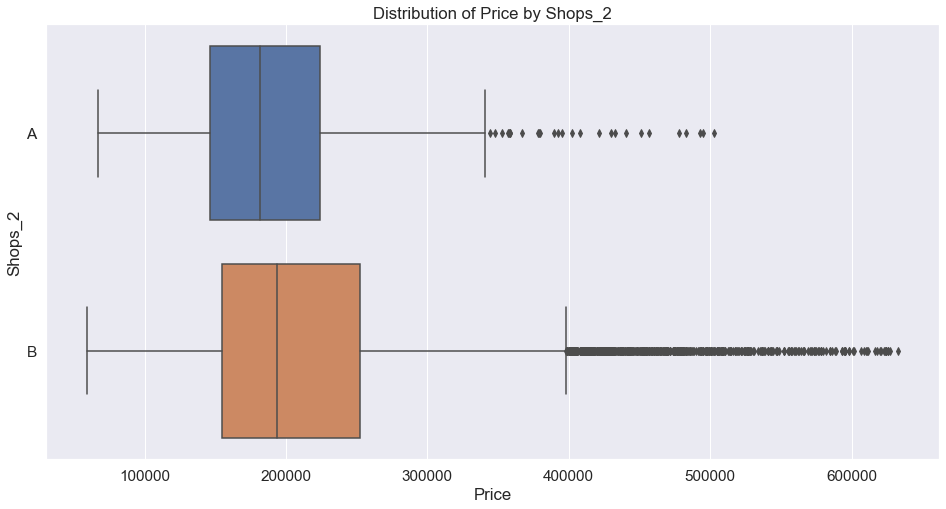

In [24]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['Price'], train_df['Shops_2'], whis=1.5)

plt.xlabel('Price')
plt.ylabel('Shops_2')
plt.title('Distribution of Price by Shops_2')
plt.show()

Можно сделать вывод, что цена особо не зависит от показателей Ecology_2, Ecology_3 и Shops_2

#### Обработка пропусков

In [25]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [26]:
##### LifeSquare можно приблизительно посчитать на основании площади кухни и общей площади
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,1.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,1.0
9,79.867477,75.085129,1.0


In [27]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [28]:
# Healthcare_1 не несет в себе особой информативности, и понять, что именно означают данные и как правильно заполнить пропуски
# невозможно. Поэтому, будет логичным просто удалить этот столбец.
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [29]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

#### Обработка выбросов

In [30]:
#### KitchenSquare. Значений свыше 20 очень мало. Думаю, будет логично заменить их медианой
train_df.loc[train_df['KitchenSquare'] > 20, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [31]:
#### в отношении Social_3, значений свыше 50 очень мало. Думаю, будет логично заменить их медианой
train_df.loc[train_df['Social_3'] > 50, 'Social_3'] = train_df['Social_3'].median()

In [32]:
#### Rooms. Так как не может быть 0 комнат и значений свыше 5 очень мало, будет логичным 0 поменять на 1, 
# а значения свыше 5 (не включ.) заменить медианой.
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [33]:
#### В HouseYear просто заменим значени, которые больше 2020 на 2020.
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [34]:
#### Здесь откидываем данные, значения которых больше 97,5% квантиля и которые меньше 2,5% квантиля
Quan_median(train_df, 'Square')
Quan_median(train_df, 'LifeSquare')
Quan_median(train_df, 'Shops_1')

In [35]:
#### HouseFloor и Floor. Как известно, этаж квартиры не может быть больше, чем всего этажей в доме.
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [36]:
Fl_HF(train_df)
# А так же заменим на медиану то, что больше 40 и 50 (всего 4 значения)
train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['Floor'] > 40, 'Floor'] = train_df['HouseFloor'].median()

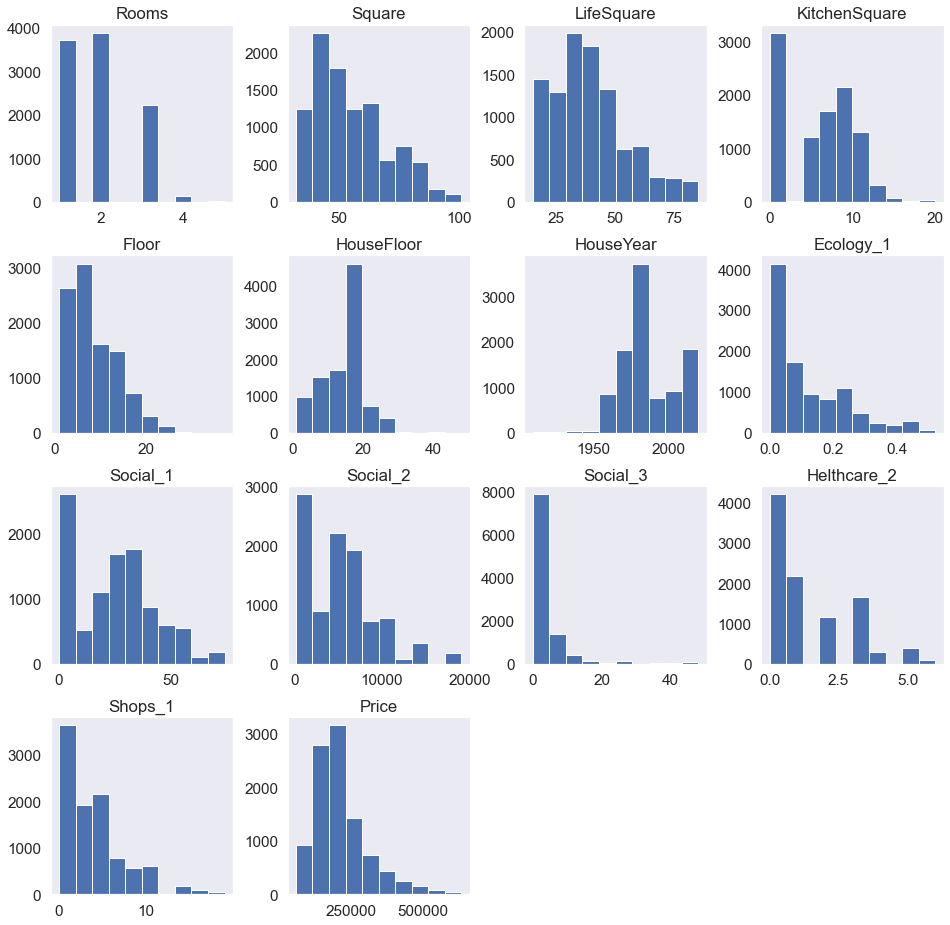

In [37]:
train_df.hist(figsize=(16,16), bins=10, grid=False);

##### После обработки выбросов можно увидеть небольшую зависимость таргета от фичей

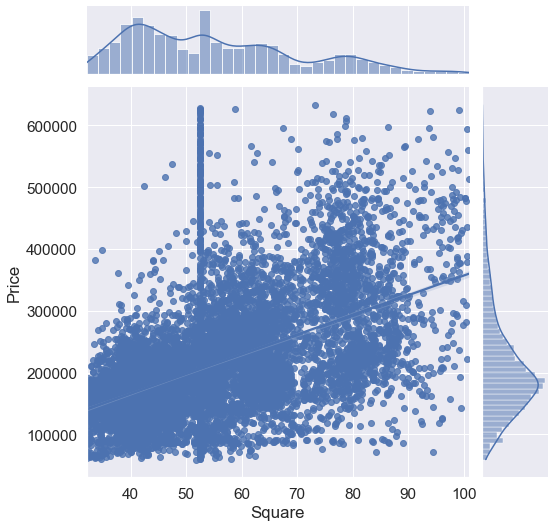

In [38]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

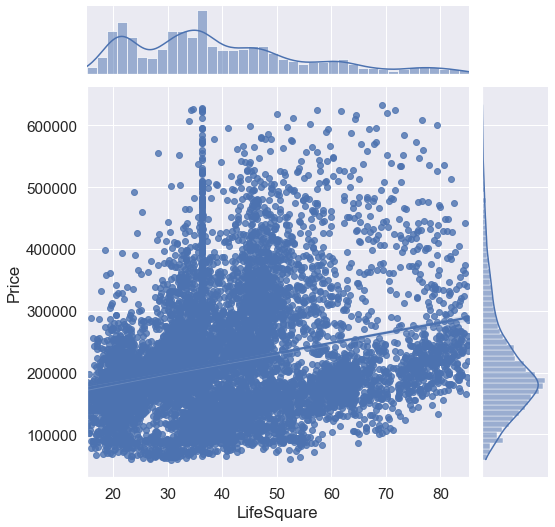

In [39]:
grid = sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### Перевод категориальных переменных в числовые

In [40]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### Отбор признаков и разбитие на train и test

In [41]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1','Shops_2']
target_name = 'Price'

In [42]:
X = train_df.drop(columns='Price')
y = train_df['Price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

#### Так же подготавливаем все данные тестового дф

In [43]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [44]:
binary_to_numbers = {'A': 0, 'B': 1}

test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

In [45]:
condition = (test_df['LifeSquare'].isna()) \
             & (~test_df['Square'].isna()) \
             & (~test_df['KitchenSquare'].isna())
        
test_df.loc[condition, 'LifeSquare'] = test_df.loc[condition, 'Square'] \
                                            - test_df.loc[condition, 'KitchenSquare'] - 3

In [46]:
test_df.drop('Healthcare_1', axis=1, inplace=True)

In [47]:
test_df.loc[test_df['KitchenSquare'] > 20, 'KitchenSquare'] = test_df['KitchenSquare'].median()
test_df.loc[test_df['Social_3'] > 50, 'Social_3'] = test_df['Social_3'].median()
test_df.loc[test_df['Rooms'] == 0, 'Rooms'] = 1
test_df.loc[test_df['Rooms'] >= 6, 'Rooms'] = test_df['Rooms'].median()
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020
Quan_median(test_df, 'Square')
Quan_median(test_df, 'LifeSquare')
Quan_median(test_df, 'Shops_1')

In [48]:
Fl_HF(test_df)
test_df.loc[test_df['HouseFloor'] > 50, 'HouseFloor'] = test_df['HouseFloor'].median()
test_df.loc[test_df['Floor'] > 40, 'Floor'] = test_df['HouseFloor'].median()

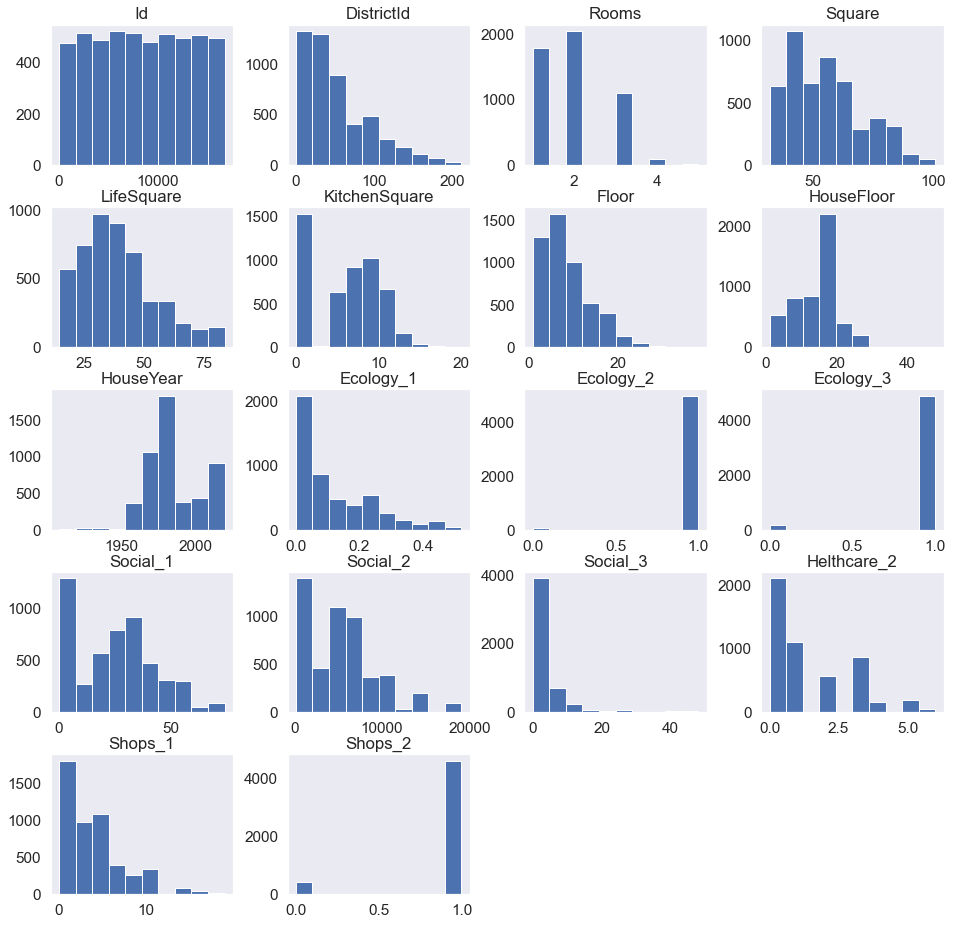

In [49]:
test_df.hist(figsize=(16,16), bins=10, grid=False);

In [50]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [51]:
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]
test_df = test_df[feature_names]

In [52]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

R2:	0.837
RMSE:	37632.695
MSE:	1416219752.383


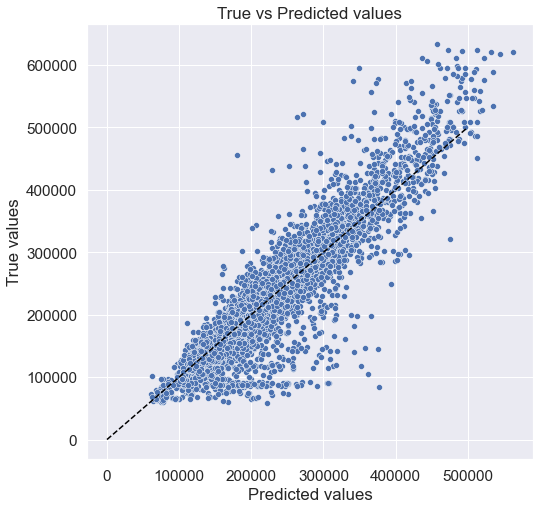

In [53]:
# Gradient Boosting decision trees 
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.713
RMSE:	49427.534
MSE:	2443081079.688


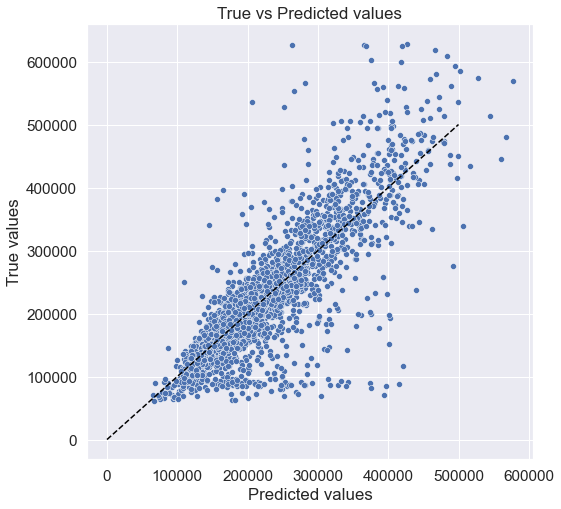

In [54]:
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

In [55]:
test_df.shape

(5000, 18)

In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   int64  
dtypes: float

In [57]:
test_df = test_df.fillna(0)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1
4,746,74,1.0,53.837056,49.837056,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1


In [58]:
y_pred_test = gb_model.predict(test_df)

In [61]:
predictions = pd.DataFrame({
    'Id': test_df["Id"],
    'Price': y_pred_test
})

In [62]:
predictions.head()

,Id,Price
0,4567,162643.204698
1,5925,125067.727371
2,960,147615.568883
3,3848,143500.619140
4,746,189949.892422


In [63]:
predictions.to_csv('LGondareva_predictions.csv', sep=',', index=False, encoding='utf-8')